### **Load Image Data and Explore it**

In [ ]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Scikit-learn (for evaluation metrics)
from sklearn.metrics import classification_report, confusion_matrix

# Optional (for reproducibility)
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sports-classification


In [ ]:
# Path from the KaggleHub log
base_dir = "/kaggle/input/sports-classification"

# Subdirectories
train_dir = f"{base_dir}/train"
val_dir   = f"{base_dir}/valid"
test_dir  = f"{base_dir}/test"

# Parameters
img_height, img_width = 224, 224   # dataset images are 224x224
batch_size = 32

# Load datasets
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# Class names
class_names = train_ds.class_names
print("Number of classes:", len(class_names))
print("Example classes:", class_names[:10])

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Number of classes: 100
Example classes: ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling']


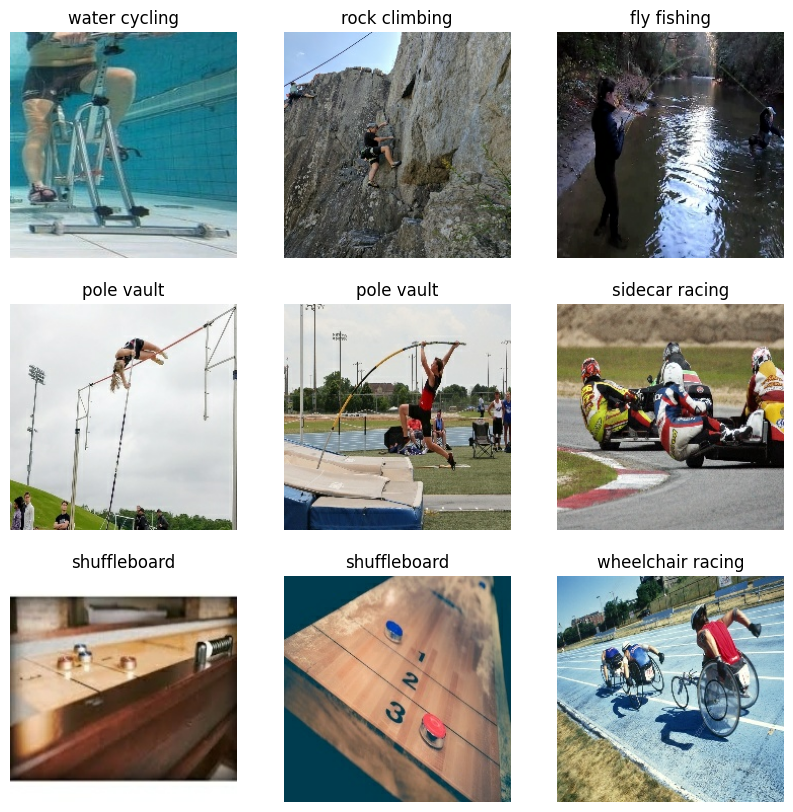

In [ ]:
# Preview some images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):   # take 1 batch
    for i in range(9):   # show first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # convert tensor -> numpy -> image
        plt.title(class_names[labels[i]])  # show class name
        plt.axis("off")


### **Preprocessing & Performance**

**Normalize images and enable prefetching for faster training:**

* `AUTOTUNE` lets TensorFlow **automatically tune the performance** of your input pipeline (e.g., how many elements to fetch in parallel).
* It makes the pipeline faster without you needing to manually set parameters.
* `.cache()` Saves the dataset in memory **after the first load**, so it doesn’t repeatedly read from disk (faster training).
* `.prefetch(AUTOTUNE)`

   * While the model is training on one batch, TensorFlow **loads the next batch in the background**.
   * This overlaps data preparation with model execution, making training faster.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (x/255.0, y)).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (x/255.0, y)).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (x/255.0, y)).cache().prefetch(AUTOTUNE)


### **Build a Simple CNN Model**

Simple baseline CNN with Conv → Pool → Dropout layers:

This CNN takes a 224×224 RGB image, passes it through 3 convolution + pooling blocks, then through dense layers, and finally predicts one of 100 classes. Dropout is used throughout to reduce overfitting.

In [ ]:
num_classes = 100

model = models.Sequential([
    layers.Conv2D(16, (3,3), activation="relu", input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),

    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),   # reduced from 256
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,574,404 (21.26 MB)

 Trainable params: 5,574,404 (21.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tqdm.keras import TqdmCallback

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[TqdmCallback(verbose=1)]
)



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 748s 2s/step - accuracy: 0.0107 - loss: 4.6465 - val_accuracy: 0.0520 - val_loss: 4.2716
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 788s 2s/step - accuracy: 0.0563 - loss: 4.1771 - val_accuracy: 0.1320 - val_loss: 3.8150
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - accuracy: 0.0928 - loss: 3.8122 - val_accuracy: 0.1700 - val_loss: 3.5759
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 741s 2s/step - accuracy: 0.1372 - loss: 3.5332 - val_accuracy: 0.2100 - val_loss: 3.2485
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 734s 2s/step - accuracy: 0.1716 - loss: 3.3091 - val_accuracy: 0.2500 - val_loss: 3.0755
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 729s 2s/step - accuracy: 0.2035 - loss: 3.1006 - val_accuracy: 0.2600 - val_loss: 2.9688
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 729s 2s/step - accuracy: 0.2302 - loss: 2.9055 - val_accuracy: 0.2840 - val_loss: 2.8768
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 746s 2s/step - accuracy: 0.2607 - loss: 2.7599 - val_accu

**Model Training Notes**

- **Training Time**: Approximately 2 hours.
  
- **Tips to Improve Accuracy**:
  - **Learning Rate Adjustment**:  
    The default Adam optimizer uses a learning rate of `0.001`. To improve accuracy, consider increasing it to `0.1` or higher.
    > ⚠️ **Caution**: A higher learning rate may cause the model to diverge or fail to converge. Monitor training carefully.

  - **Increase Number of Epochs**:  
    Training for more epochs may help the model learn better, especially when combined with a tuned learning rate.

- **Next Steps**:
  - Experiment with learning rates (e.g., 0.01, 0.1).
  - Gradually increase epochs while monitoring for overfitting.
  - Use learning rate scheduling or early stopping if needed.

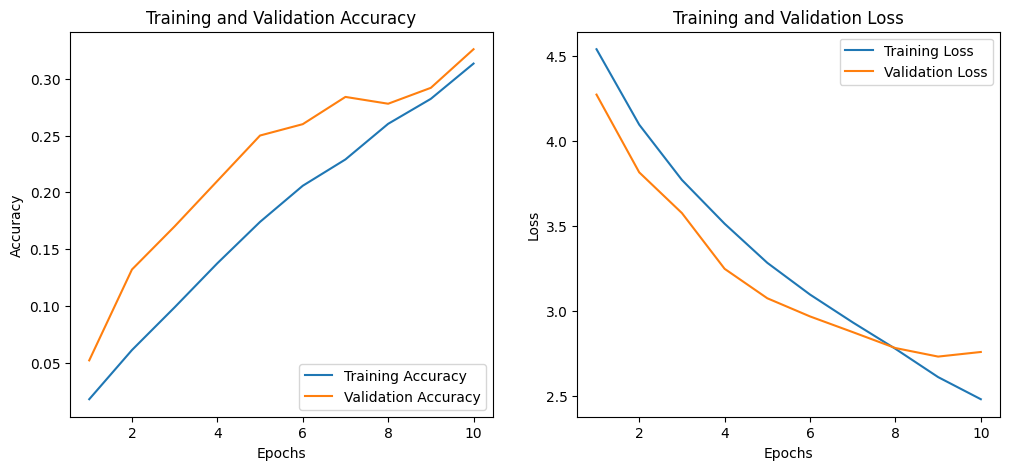

In [ ]:
# Extract history values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()


### **Build ResNet50 and MobileNetV2**

* Choose **MobileNetV2** if you want **faster training and lower memory use**, even with 100 classes.
* Choose **ResNet50** if you want **higher accuracy** and can afford **slower training & heavier model size**.


In [ ]:
def build_resnet(num_classes):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

In [ ]:
def build_mobilenet(num_classes):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

**👉 Typical safe ranges for Adam are:**

* **1e-3 (0.001)** → default, usually works well
* **1e-4 (0.0001)** → good for fine-tuning pretrained models
* **1e-2 (0.01)** → aggressive but sometimes okay for shallow or frozen networks
* **0.05** → almost always unstable

In [ ]:
from tensorflow.keras import optimizers
from tqdm.keras import TqdmCallback

# MobileNetV2
mobilenet_model = build_mobilenet(num_classes)
mobilenet_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("Training MobileNetV2...")
history_mobilenet = mobilenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=0,  # suppress default Keras progress bar
    callbacks=[TqdmCallback(verbose=1)]  # tqdm progress bar
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training MobileNetV2...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]